In [1]:
import pickle
import pandas as pd
import itertools
from collections import Counter
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import word2vec
import os
import string
import ast
import matplotlib.pyplot as plt

# Key models used =
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# NLTK library downloads
nltk.download('stopwords')
nltk.download('punkt')  

[nltk_data] Downloading package stopwords to C:\Users\Khanh
[nltk_data]     Phan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Khanh
[nltk_data]     Phan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Setup Functions

In [2]:
# A function used to build a vocabulary based on descending word frequencies 
def build_vocab(sentences):
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

In [3]:
# A function used to learn word embeddings through Word2vec module
def get_embeddings(inp_data, vocabulary_inv, size_features=100,
                   mode='skipgram',
                   min_word_count=2,
                   context=5):
    model_name = "embedding"
    model_name = os.path.join(model_name)
    num_workers = 15  # Number of threads to run in parallel
    downsampling = 1e-3  # Downsample setting for frequent words
    print('Training Word2Vec model...')
    # use inp_data and vocabulary_inv to reconstruct sentences
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    if mode == 'skipgram':
        sg = 1
        print('Model: skip-gram')
    elif mode == 'cbow':
        sg = 0
        print('Model: CBOW')
    embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                        sg=sg,
                                        vector_size=size_features,
                                        min_count=min_word_count,
                                        window=context,
                                        sample=downsampling)
    print("Saving Word2Vec model {}".format(model_name))
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25,
                                                     embedding_model.vector_size)
    return embedding_weights

In [4]:
def preprocess_df(df):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    # prepare translation table to translate punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row["text"]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    df["text"] = preprocessed_sentences
    return df

# Load in dataframes, feature engineering

In [5]:
data_path = "data/"

df_train = pd.read_parquet(data_path + "train.parquet")
df_test = pd.read_parquet(data_path + "test.parquet")

In [6]:
df_train["text"] = df_train["review"]
df_test["text"] = df_test["review"]
df_train = preprocess_df(df_train)
df_test = preprocess_df(df_test)

In [49]:
df_train['label'].unique()

array(['american (traditional)', 'american (new)', 'mexican', 'chinese',
       'mediterranean', 'italian', 'thai', 'asian fusion',
       'canadian (new)', 'japanese'], dtype=object)

In [7]:
print(f"Training Data: {df_train.shape}")
print(f"Test Data: {df_test.shape}")

Training Data: (13144, 63)
Test Data: (10000, 62)


In [8]:
# Overview of which columns are sparse
pd.set_option('display.max_rows', None)
df_train.count(axis = 'rows')

id                                       13144
attributes.HappyHour                      1256
attributes.Ambience                      11338
hours.Tuesday                            10412
postal_code                              13144
attributes.AgesAllowed                      12
attributes.GoodForDancing                 1111
attributes.OutdoorSeating                11845
hours.Saturday                           10525
attributes.Corkage                         182
longitude                                13144
name                                     13144
attributes.BusinessAcceptsCreditCards     8814
attributes.RestaurantsTableService        4428
attributes.RestaurantsReservations       12135
hours.Friday                             10706
attributes.RestaurantsPriceRange2        12296
attributes.WiFi                          10222
attributes.ByAppointmentOnly               113
attributes.Music                          1224
attributes.NoiseLevel                    10552
attributes.BY

In [9]:
df_train.count(axis='rows')[df_train.count(axis='rows') > 10000]

id                                     13144
attributes.Ambience                    11338
hours.Tuesday                          10412
postal_code                            13144
attributes.OutdoorSeating              11845
hours.Saturday                         10525
longitude                              13144
name                                   13144
attributes.RestaurantsReservations     12135
hours.Friday                           10706
attributes.RestaurantsPriceRange2      12296
attributes.WiFi                        10222
attributes.NoiseLevel                  10552
state                                  13144
attributes.Alcohol                     11173
attributes.HasTV                       11268
attributes                             12913
hours.Wednesday                        10618
attributes.RestaurantsGoodForGroups    12325
attributes.BusinessParking             11559
review_count                           13144
is_open                                13144
city      

In [10]:
# Upon exploration on the file, the following was observed for the attributes.Ambience column 
# attributes.BusinessParking is another we can do similarly on 
df_train["attributes.Ambience"].head(5)

0    b"{'romantic': False, 'intimate': False, 'clas...
1    b"{'romantic': False, 'intimate': False, 'tour...
2                                                 None
3    b"{'romantic': False, 'intimate': False, 'clas...
4    b"{'romantic': False, 'intimate': False, 'tour...
Name: attributes.Ambience, dtype: object

In [11]:
# Function to split the ambience column into separate columns for OneHotEncoding
def ambience_column_parse(x):
    if pd.isna(x):
        return {}
    if isinstance(x, str):
        s = x.strip()
        # Remove b"____" and b'None' seen in columns
        if s == "b'None'":
            return {}
        elif s.startswith('b"') and s.endswith('"'):
            s = s[2:-1]
        return ast.literal_eval(s)
    return {}

def split_ambience_column(df): 
    df["attributes.Ambience"] = df["attributes.Ambience"].apply(ambience_column_parse)
    ambience_df = pd.json_normalize(df["attributes.Ambience"])
    df = pd.concat([df.drop(columns = ["attributes.Ambience"]), ambience_df], axis = 1)
    return df

In [12]:
# Perform split
df_train = split_ambience_column(df_train)
df_test = split_ambience_column(df_test)

In [13]:
# Can verify new columns appended at the end
df_train.columns

Index(['id', 'attributes.HappyHour', 'hours.Tuesday', 'postal_code',
       'attributes.AgesAllowed', 'attributes.GoodForDancing',
       'attributes.OutdoorSeating', 'hours.Saturday', 'attributes.Corkage',
       'longitude', 'name', 'attributes.BusinessAcceptsCreditCards',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsReservations', 'hours.Friday',
       'attributes.RestaurantsPriceRange2', 'attributes.WiFi',
       'attributes.ByAppointmentOnly', 'attributes.Music',
       'attributes.NoiseLevel', 'attributes.BYOB', 'state',
       'attributes.Alcohol', 'attributes.HasTV', 'attributes',
       'attributes.BYOBCorkage', 'hours.Wednesday', 'hours.Sunday',
       'attributes.RestaurantsGoodForGroups', 'attributes.Open24Hours',
       'attributes.BusinessParking', 'attributes.DogsAllowed',
       'attributes.HairSpecializesIn', 'review_count', 'is_open',
       'attributes.Caters', 'attributes.CoatCheck', 'attributes.BikeParking',
       'hours.Monday', 'at

In [14]:
# Desired attributes for ML
features_onehot = ["attributes.OutdoorSeating", 
                   "attributes.RestaurantsReservations", 
                   "attributes.RestaurantsPriceRange2", 
                   "attributes.WiFi", 
                   "attributes.Alcohol", 
                   "attributes.HasTV",
                   "attributes.RestaurantsGoodForGroups", 
                   "attributes.Caters",
                   "attributes.BikeParking", 
                   "attributes.RestaurantsTakeOut", 
                   "attributes.RestaurantsDelivery",
                   "attributes.GoodForKids", 
                   "romantic", 
                   "intimate", 
                   "classy", 
                   "hipster", 
                   "divey",
                   "touristy", 
                   "trendy", 
                   "upscale", 
                   "casual"
                   ]


# Additional ones to consider exploring: 
# attributes.Noiselevel
# attributes.BusinessParking (will require extra processing)
# attributes.RestaurantsAttire (will also require additional processing)

In [15]:
# Initialize PCA
pca = PCA()
full_onehot_df = pd.get_dummies(df_train[features_onehot], columns = features_onehot).astype(int)
scaled_onehot = StandardScaler().fit_transform(full_onehot_df)
pca.fit_transform(scaled_onehot)

array([[ 1.59304987e+00,  1.22543660e+00,  1.17382123e-01, ...,
         1.61650511e-14, -7.78013778e-15, -9.38797166e-14],
       [ 1.89766899e+00, -1.09848195e+00, -2.22996989e-01, ...,
         1.95419634e-15, -5.44095048e-14, -2.18262423e-14],
       [-7.81435988e+00, -2.74753231e-01, -3.94642453e-01, ...,
         6.16841951e-14, -9.08803312e-14,  4.62980397e-13],
       ...,
       [ 2.04457257e-01, -1.92487250e+00, -2.84278112e-01, ...,
         1.05538005e-13,  1.03186654e-13,  1.55530108e-12],
       [ 1.79888701e+00,  6.70130538e-01,  1.38123270e-01, ...,
         3.11530619e-14,  9.25840236e-14,  8.09426820e-15],
       [ 4.74854277e-01,  2.43077879e+00,  3.06973160e-01, ...,
         5.29134332e-14,  1.11291282e-13,  1.83638312e-14]])

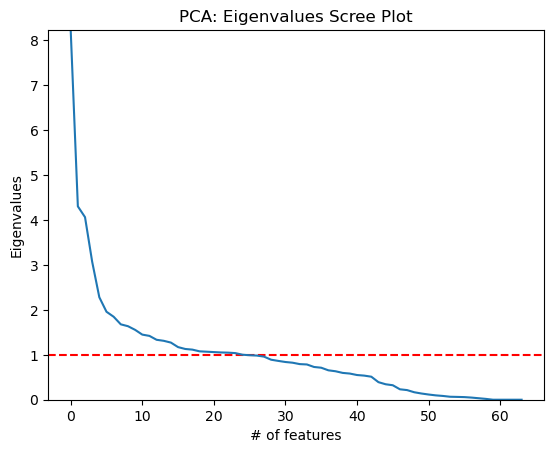

Number of components with eigenvalue >= 1: 25


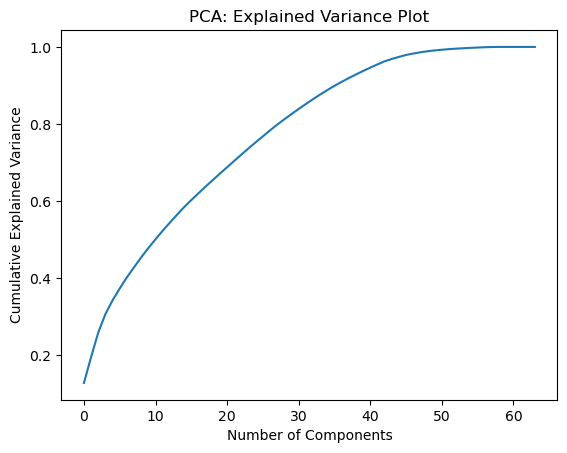

Number of components to explain 70% variance: 22


In [16]:
# https://sanchitamangale12.medium.com/scree-plot-733ed72c8608

# Scree plot showing elbow plot
plt.ylabel('Eigenvalues')
plt.xlabel('# of features')
plt.title('PCA: Eigenvalues Scree Plot')
plt.ylim(0, max(pca.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y =1, color = 'r', linestyle = '--')
plt.plot(pca.explained_variance_)
plt.show()

num_components_above_1 = np.sum(pca.explained_variance_ >= 1) # https://docs.displayr.com/wiki/Kaiser_Rule
print("Number of components with eigenvalue >= 1:", num_components_above_1)

# Cumulative Variance Plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.title('PCA: Explained Variance Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

n_components_70 = np.argmax(cumulative_variance >= 0.70) + 1  # +1 since index starts at 0
print(f"Number of components to explain 70% variance: {n_components_70}")


In [17]:
# Initialize PCA to reduce the columns that are to be onehotencoded via get_dummies()
n_components=25

pca = PCA(n_components=n_components)

In [18]:
def pca_columns(df, column_list, n_components): 
    # One hot encoding for each of the columns in the columns we want for analysis
    X = pd.get_dummies(df[column_list], columns = column_list).astype(int)
    X_scaled = StandardScaler().fit_transform(X)

    # PCA 
    X_pca = pca.fit_transform(X_scaled)
    column_labels = [f"PC {i + 1}" for i in range(n_components)]

    # Creation of principal component dataframe
    pcs_df = pd.DataFrame(data = X_pca, columns = column_labels, index = X.index)

    # Add back in text and review column
    pcs_df[["text", "review"]] = df[["text", "review"]]

    return pcs_df

In [19]:
# Change original dataframe to be just the ten PCA columns with text and review

df_train_withPCA = pca_columns(df_train, features_onehot, n_components)
df_test_withPCA = pca_columns(df_test, features_onehot, n_components)

In [20]:
# Split data to have a "validation" set of sorts (OLD CODE)

X_train, X_test, y_train, y_test = train_test_split(df_train_withPCA, df_train["label"], test_size=0.2, random_state=42)

In [21]:
print(f"Training Partition Data: {X_train.shape}")
print(f"Test Partition Data: {X_test.shape}")

Training Partition Data: (10515, 27)
Test Partition Data: (2629, 27)


# Exploring ML Models

In [22]:
model_accuracy_dict = {}

In [23]:
# Encode labels for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

#### Model 1: Logistic Regression with TfidfVectorizer on the review, no other features

In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
print("Initializing Model 1...")
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_train["text"]) # Returns sparse (?)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, df_train["label"], test_size=0.2, random_state=42)

# Gridsearch to find best value of C
print("Performing grid search for best C...")
parameters = {'C': [1, 10, 100, 1000, 10000, 100000, 500, 300, 15, 20]}

grid_clf = GridSearchCV(LogisticRegression(max_iter = 100000000), parameters, cv = 5, verbose=2)
grid_clf.fit(X_train_tfidf, y_train_tfidf)

recommended_C = grid_clf.best_params_['C']
print(f"Best C parameter: {recommended_C}")

# Evaluate on validation set
print("Fitting Logistic Regression with recommended C, then testing on validation set...")
clf = LogisticRegression(max_iter=100000000, C = recommended_C).fit(X_train_tfidf, y_train_tfidf)
preds = clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test_tfidf, preds)
model_accuracy_dict["Model 1"] = accuracy
print("Model 1 Accuracy:", accuracy)

Initializing Model 1...
Performing grid search for best C...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................................................C=1; total time=   2.9s
[CV] END ................................................C=1; total time=   2.9s
[CV] END ................................................C=1; total time=   2.5s
[CV] END ................................................C=1; total time=   2.9s
[CV] END ................................................C=1; total time=   2.8s
[CV] END ...............................................C=10; total time=   4.7s
[CV] END ...............................................C=10; total time=   4.2s
[CV] END ...............................................C=10; total time=   4.3s
[CV] END ...............................................C=10; total time=   3.9s
[CV] END ...............................................C=10; total time=   5.1s
[CV] END ..............................................C=100; total 

#### Model 2: Logistic Regression with TfidfVectorizer and Principal Components

In [ ]:
# "This estimator allows different columns or column subsets of the input to be transformed separately 
# and the features generated by each transformer will be concatenated to form a single feature space"
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

print("Initializing Model 2...")
pc_columns = [f'PC {i}' for i in range(1, 20)]

ct = ColumnTransformer(
    [("text_preprocess", TfidfVectorizer(), "text"),
     ("pcs", "passthrough", pc_columns) 
    ]
)
X_trans = ct.fit_transform(df_train_withPCA)

X_train_transformer, X_test_transformer, y_train_transformer, y_test_transformer = train_test_split(X_trans, df_train["label"], test_size=0.2, random_state=42)

# Gridsearch to find best value of C
print("Performing grid search for best C...")
parameters = {'C': [1, 10, 100, 1000, 10000, 100000, 500, 300, 15, 20]}

grid_clf = GridSearchCV(LogisticRegression(max_iter = 100000000), parameters, cv = 5, verbose = 2)
grid_clf.fit(X_train_transformer, y_train_transformer)
recommended_C = grid_clf.best_params_['C']
print(f"Best C parameter: {recommended_C}")

# Evaluate on validation set
print("Fitting Logistic Regression with recommended C, then testing on validation set...")
clf = LogisticRegression(max_iter=100000000, C = recommended_C).fit(X_train_transformer, y_train_transformer)
preds = clf.predict(X_test_transformer)
accuracy = accuracy_score(y_test_transformer, preds)
model_accuracy_dict["Model 2"] = accuracy
print("Model 2 Accuracy:", accuracy)

Initializing Model 2...
Performing grid search for best C...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................................................C=1; total time=   9.0s
[CV] END ................................................C=1; total time=   9.6s
[CV] END ................................................C=1; total time=  10.0s
[CV] END ................................................C=1; total time=  10.2s
[CV] END ................................................C=1; total time=  11.6s
[CV] END ...............................................C=10; total time=  21.3s
[CV] END ...............................................C=10; total time=  21.7s
[CV] END ...............................................C=10; total time=  18.3s
[CV] END ...............................................C=10; total time=  20.6s
[CV] END ...............................................C=10; total time=  19.4s
[CV] END ..............................................C=100; total 

#### Model 3: Logistic Regression with TfidfVectorizer, Principal Components, and Additional Numeric Columns

In [26]:
print("Initializing Model 3...")
ct = ColumnTransformer(
    [("text_preprocess", TfidfVectorizer(stop_words = "english", max_df = 0.3), "text"),
     ("pcs", StandardScaler(), pc_columns), 
     ("location", StandardScaler(), ['latitude', 'longitude']), 
     ("other", StandardScaler(), ['review_count', 'stars'])
    ]
)

numeric_columns_train = df_train[["longitude", "latitude", "stars", "review_count"]]
df_withLocation = pd.concat([df_train_withPCA, numeric_columns_train], axis=1)

X_trans = ct.fit_transform(df_withLocation)

X_train_transformer, X_test_transformer, y_train_transformer, y_test_transformer = train_test_split(X_trans, df_train["label"], test_size=0.2, random_state=42)

# Gridsearch to find best value of C
print("Performing grid search for best C...")
parameters = {'C': [1, 3, 5, 4, 6, 7, 10, 100]}

grid_clf = GridSearchCV(LogisticRegression(max_iter = 100000000, n_jobs = -1), parameters, cv = 5, verbose = 2)
grid_clf.fit(X_train_transformer, y_train_transformer)
recommended_C = grid_clf.best_params_['C']
print(f"Best C parameter: {recommended_C}")

# Evaluate on validation set
print("Fitting Logistic Regression with recommended C, then testing on validation set...")
clf = LogisticRegression(max_iter=100000000, C = recommended_C, n_jobs = -1).fit(X_train_transformer, y_train_transformer)
preds = clf.predict(X_test_transformer)
accuracy = accuracy_score(y_test_transformer, preds)
model_accuracy_dict["Model 3"] = accuracy
print("Model 3 Accuracy:", accuracy)

Initializing Model 3...
Performing grid search for best C...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................................................C=1; total time=   5.9s
[CV] END ................................................C=1; total time=   5.3s
[CV] END ................................................C=1; total time=   5.2s
[CV] END ................................................C=1; total time=   5.2s
[CV] END ................................................C=1; total time=   5.4s
[CV] END ................................................C=3; total time=   7.6s
[CV] END ................................................C=3; total time=   7.8s
[CV] END ................................................C=3; total time=   8.1s
[CV] END ................................................C=3; total time=   7.3s
[CV] END ................................................C=3; total time=   8.2s
[CV] END ................................................C=5; total t

### Model 4: AdaBoost with TfidfVectorizer, Principal Components, and Additional Numeric Columns

In [30]:
print("Initializing Model 4...")

# Gridsearch to find best parameters
# print("Performing grid search for parameters...")
# parameters = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.5, 1.0],
#     'estimator__max_depth': [1, 2, 3],
#     'algorithm': ['SAMME', 'SAMME.R']
# }

# grid_clf = GridSearchCV(
#     estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
#     param_grid=parameters,
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )
# grid_clf.fit(X_train_transformer, y_train_transformer)
# print("Best Parameters:", grid_clf.best_params_)


# # Evaluate on validation set
# print("Fitting model with recommended parameters, then testing on validation set...")
# ada_clf = grid_clf.best_estimator_
ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators = 180, learning_rate = 0.01, algorithm = "SAMME").fit(X_train_transformer, y_train_transformer)
preds = ada_clf.predict(X_test_transformer)
accuracy = accuracy_score(y_test_transformer, preds)
model_accuracy_dict["Model 4"] = accuracy
print("Model 4 Accuracy:", accuracy)

Initializing Model 4...
Model 4 Accuracy: 0.6705971852415367


### Model 5: LinearSVC with TfidfVectorizer, Principal Components, and Additional Numeric Columns 

In [32]:
print("Initializing Model 5...")

svc = CalibratedClassifierCV(LinearSVC(C=1, max_iter=50000), cv=3).fit(X_train_transformer, y_train_transformer)
preds = svc.predict(X_test_transformer)
accuracy = accuracy_score(y_test_transformer, preds)
model_accuracy_dict["Model 5"] = accuracy
print("Model 5 Accuracy:", accuracy)


Initializing Model 5...
Model 5 Accuracy: 0.8151388360593381


### Model 6: Random Forest with TfidfVectorizer, Principal Components, and Additional Numeric Columns 

In [33]:
print("Initializing Model 6...")

rf_clf = RandomForestClassifier(
    n_estimators=1500,       
    max_depth=None,           
    max_features='sqrt',   
    n_jobs=-1,     
    random_state=42,
    #class_weight = "balanced",
    verbose=0
)
rf_clf.fit(X_train_transformer, y_train_transformer)
preds = rf_clf.predict(X_test_transformer)
accuracy = accuracy_score(y_test_transformer, preds)
model_accuracy_dict["Model 6"] = accuracy
print("Model 6 Accuracy:", accuracy)


Initializing Model 6...
Model 6 Accuracy: 0.7683529859262077


### Model 7: XGBoost with TfidfVectorizer, Principal Components, and Additional Numeric Columns 

In [34]:
y_train_enc = le.fit_transform(y_train_transformer)
y_test_enc = le.fit_transform(y_test_transformer)

In [35]:
print("Initializing Model 7...")
xgboost_model = XGBClassifier(n_estimators = 1000, max_depth = 6, learning_rate = 0.1, n_jobs = -1)
xgboost_model.fit(X_train_transformer, y_train_enc)
xgboost_preds = xgboost_model.predict(X_test_transformer)
accuracy = accuracy_score(y_test_enc, xgboost_preds)
model_accuracy_dict["Model 7"] = accuracy
print("Model 7 Accuracy:", accuracy)


Initializing Model 7...
Model 7 Accuracy: 0.800304298212248


### Model 8: Final Model Ensemble with TfidfVectorizer, Principal Components, and Additional Numeric Columns 

In [36]:
# Hyperparameters as determined on previous run
# 0.8216051730696082, [4, 1, 2, 1, 4]
# 0.8197033092430582, [5, 2, 2, 1, 4]
# 0.8200836820083682, [4, 2, 2, 1, 3]
# 0.8200836820083682, [4, 2, 2, 1, 4]

In [37]:
print("Initializing Model 8...")
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=100000000, C = 4, n_jobs = -1)),
        ('xgb', XGBClassifier(n_estimators = 1500, max_depth = 6, learning_rate = 0.1, n_jobs = -1)), 
        ('rf', RandomForestClassifier(n_estimators = 1500, max_depth = None, max_features = 'sqrt', n_jobs = -1)),
        ('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators = 1500, learning_rate = 0.1, algorithm = "SAMME")),
        ('svc', CalibratedClassifierCV(LinearSVC(C=1.0, max_iter=50000), cv=3))
    ],
    voting='soft', 
    n_jobs= -1,
    weights = [3, 1, 1, 1, 3]
)
voting_clf.fit(X_train_transformer, y_train_transformer)

preds = voting_clf.predict(X_test_transformer)
accuracy = accuracy_score(y_test_transformer, preds)
model_accuracy_dict["Model 8"] = accuracy
print("Model 8 Accuracy:", accuracy)


Initializing Model 8...
Model 8 Accuracy: 0.8204640547736782


## Final Table of Accuracies

In [42]:
# Generate Table of Results
df_scores = pd.DataFrame(list(model_accuracy_dict.items()), columns=['Model', 'Accuracy'])
df_scores

,Model,Accuracy
0,Model 1,0.795740
1,Model 2,0.801065
2,Model 3,0.806771
3,Model 4,0.670597
4,Model 5,0.815139
5,Model 6,0.768353
6,Model 7,0.800304
7,Model 8,0.820464


### Train with full data

In [39]:
# Test Processing
numeric_columns_test = df_test[["longitude", "latitude", "stars", "review_count"]]
test_df_withLocation = pd.concat([df_test_withPCA, numeric_columns_test], axis=1)

X_test_trans = ct.transform(test_df_withLocation)

In [40]:
# Initialize and fit to full data
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=100000000, C = 4, n_jobs = -1)),
        ('xgb', XGBClassifier(n_estimators = 1500, max_depth = 6, learning_rate = 0.1, n_jobs = -1)), 
        ('rf', RandomForestClassifier(n_estimators = 1500, max_depth = None, max_features = 'sqrt', n_jobs = -1)),
        ('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators = 1500, learning_rate = 0.1, algorithm = "SAMME")),
        ('svc', CalibratedClassifierCV(LinearSVC(C=1.0, max_iter=50000), cv=3))
    ],
    voting='soft',
    n_jobs= -1,
    weights = [3, 1, 1, 1, 3]
)
voting_clf.fit(X_trans, df_train["label"])

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=4, max_iter=100000000,
                                                 n_jobs=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=No...
                                            n_estimators=1500, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                             ('rf',
                              RandomForestClassifier(n_estimators=1500,
                                                     n_jobs=-1)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 estimator=DecisionTreeClassifier(max_depth=1),
                                                 learning_rate=0.1,
                                                 n_estimators=1500)),
                             ('svc',
                              CalibratedClassifierCV(cv=3,
                                                     estimator=LinearSVC(max_iter=50000)))],
                 n_jobs=-1, voting='soft', weights=[3, 1, 1, 1, 3])

In [41]:
# Make predictions on the test set
preds = voting_clf.predict(X_test_trans)

# Creation of output prediction file

In [43]:
# in your implemetation, create the output file using the same format
dic = {"Id": [], "Predicted": []}
for i, pred in enumerate(preds):
    dic["Id"].append(i)
    dic["Predicted"].append(pred)

dic_df = pd.DataFrame.from_dict(dic)
dic_df.to_csv(data_path + "predicted.csv", index=False)